# Heart Rate Prediction

Assumptions: series don't impact each other.

Not all readings start at exactly 30 seconds. We will shift to align all series on 30 second intervals

Need to figure out discontinuities

Key Considerations:
- Probabilistic: need a range of outcomes, not just point estimates
- Explainability: want to be able to understand why the model is making predictions
- Speed: some design choices were made under time constraints that may not be applicable to a live app setting

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
data = pd.read_csv('data/dataset_for_ds_candidate.csv',
                    usecols = ['ID',
                              'TIME_SINCE_START_IN_SECONDS',
                              'CW_SIGNAL_TYPE',
                              'SIGNAL_VALUE'])

### Inspect Data

In [3]:
print(data.head(5))
print(data.tail(5))


   ID  TIME_SINCE_START_IN_SECONDS CW_SIGNAL_TYPE  SIGNAL_VALUE
0   1                           30             HR         112.0
1   1                           60             HR         112.0
2   1                           90             HR         113.0
3   1                          120             HR         111.0
4   1                          150             HR         112.0
          ID  TIME_SINCE_START_IN_SECONDS CW_SIGNAL_TYPE  SIGNAL_VALUE
2546264  147                        75515           SPO2          95.0
2546265  147                        75545           SPO2          95.0
2546266  147                        75605           SPO2          94.0
2546267  147                        75635           SPO2          94.0
2546268  147                        75664           SPO2          94.0


In [4]:
print(data.describe())

                 ID  TIME_SINCE_START_IN_SECONDS  SIGNAL_VALUE
count  2.546269e+06                 2.546269e+06  2.546269e+06
mean   7.248366e+01                 2.892031e+05  8.926851e+01
std    3.951853e+01                 3.189487e+05  1.461936e+01
min    1.000000e+00                 2.900000e+01  0.000000e+00
25%    4.000000e+01                 7.284100e+04  8.000000e+01
50%    6.500000e+01                 1.787590e+05  9.400000e+01
75%    1.080000e+02                 3.889030e+05  9.800000e+01
max    1.470000e+02                 2.005009e+06  2.420000e+02


### Initial Impressions
We appear to have a dataset that takes 2 signals (HR, SP02) from patients (ID) at 30 second intervals (TIME_SINCE_START_IN_SECONDS). Immediately, we need to do some data quality checks to ensure that we can work with the data:


1) We need to ensure the time steps are evenly spaced for our time series models to work (note that some records are 29 seconds apart) and we need to handle the gaps

2) For each ID/CW_SIGNAL_TYPE combination, we need exactly one reading at each time step

Let's transform the data to make it a little bit easier to work with

## Transform - Start

In [5]:
data_pvt = data.pivot_table(index=['ID','TIME_SINCE_START_IN_SECONDS'],
           columns='CW_SIGNAL_TYPE',
           values=['SIGNAL_VALUE'],
           aggfunc='mean') # when there are duplicates, we take the average

data_pvt['SIGNAL_VALUE']['HR'].isna().sum()/data_pvt.shape[0] # so we have 3,164 records where we have an SPO2 reading but not an HR reading

# data_pvt['SIGNAL_VALUE']['SPO2'].isna().sum()/data_pvt.shape[0] # 9 percent of HR readings don't have SPO2. How to handle missing?

0.0023723298168267463

For this to work, we need regular, complete intervals. 

In [6]:
data_pvt.columns = ['_'.join(col) for col in data_pvt.columns.values]
data_pvt.head()

SIGNAL_VALUE_HR  SIGNAL_VALUE_SPO2
ID TIME_SINCE_START_IN_SECONDS                                    
1  30                                     112.0               98.0
   60                                     112.0               99.0
   90                                     113.0               98.0
   120                                    111.0               99.0
   150                                    112.0               98.0

In [7]:
data_pvt2 = data_pvt.reset_index(level=[1])

data_pvt2['time_diff'] = data_pvt2.groupby(level=0)['TIME_SINCE_START_IN_SECONDS'].diff()
# # fill na with 0
data_pvt2['time_diff'] = data_pvt2['time_diff'].fillna(0)
data_pvt2['time_step'] = (data_pvt2['time_diff'] / 30).round().astype(int)
# data_pvt2.loc[data_pvt2['time_step']>1]
data_pvt2['n_time_steps'] =  data_pvt2.groupby(level=0)['time_step'].cumsum()
# data_pvt2.head()
data_pvt2.info()
data_pvt2[15:30]

<class 'pandas.core.frame.DataFrame'>
Index: 1333710 entries, 1 to 147
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   TIME_SINCE_START_IN_SECONDS  1333710 non-null  int64  
 1   SIGNAL_VALUE_HR              1330546 non-null  float64
 2   SIGNAL_VALUE_SPO2            1215538 non-null  float64
 3   time_diff                    1333710 non-null  float64
 4   time_step                    1333710 non-null  int64  
 5   n_time_steps                 1333710 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 71.2 MB


,TIME_SINCE_START_IN_SECONDS,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2,time_diff,time_step,n_time_steps
ID,,,,,,
1,480,114.0,98.0,30.0,1,15
1,510,114.0,99.0,30.0,1,16
1,540,112.0,99.0,30.0,1,17
1,570,112.0,99.0,30.0,1,18
1,599,115.0,96.0,29.0,1,19
1,629,113.0,100.0,30.0,1,20
1,660,114.0,98.0,31.0,1,21
1,690,115.0,98.0,30.0,1,22
1,720,114.0,99.0,30.0,1,23


In [8]:
data_pvt3 = data_pvt2.reset_index()
data_pvt3.head()
id_time_range = (
    data_pvt3.reset_index().groupby('ID')['n_time_steps']
    .apply(lambda x: pd.RangeIndex(start=x.min(), stop=x.max() + 1,step=1))
    .explode()
    .reset_index()
    .rename(columns={0: 'n_time_steps'})
)
id_time_range
# # Create a full index of id and time
full_index = id_time_range.merge(data_pvt3[['ID']].drop_duplicates(), on='ID')
# full_index.groupby('ID')['n_time_steps'].agg(['min','max']).to_csv('./data/series_ranges.csv')

In [9]:
df_filled = (
    full_index.merge(data_pvt3, on=['ID', 'n_time_steps'], how='left')
    .sort_values(['ID', 'n_time_steps'])
)

df_filled['SIGNAL_VALUE_HR'].isna().sum()/df_filled.shape[0] 

# 6% of our records are missing which suggests we have some gaps
# cases where there are multiple readings within a 30 second window!
df_filled_agg = df_filled.groupby(['ID','n_time_steps']).agg('mean').reset_index()


In [10]:
# example of multiple readings w/in 30 second window
# check = df_filled.groupby(['ID','n_time_steps'])['n_time_steps'].agg('count')
# check.loc[check.values>1]

# data.loc[(data['ID']==8) & (abs(data['TIME_SINCE_START_IN_SECONDS'] - 8457*30) < 300)]

<Axes: xlabel='n_time_steps'>

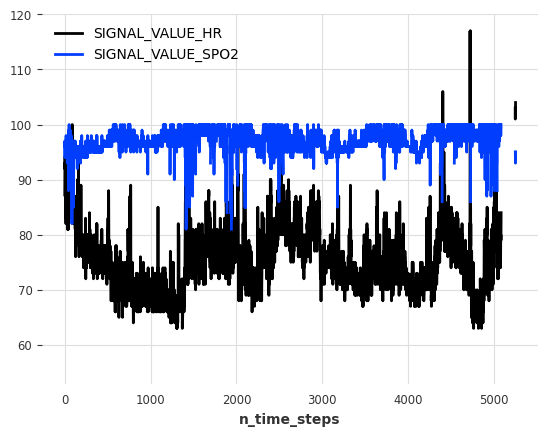

In [11]:
from darts import TimeSeries
ts_g = TimeSeries.from_group_dataframe(df_filled_agg,
                                       group_cols=['ID'],
                               time_col='n_time_steps',
                               value_cols=['SIGNAL_VALUE_HR',
                                           'SIGNAL_VALUE_SPO2']
                                     )
# 
ts_g[1]['SIGNAL_VALUE_HR'].plot()
ts_g[1]['SIGNAL_VALUE_SPO2'].plot()

In [12]:
# gaps
# approach: fill gaps up to certain point n
# take longest contiguous series
# track number of records lost

# I considered breaking up until multiple series, but in interest of time chose the former approach
# the reason is i didn't want to predict on interpolated values
gap_list = [ts.gaps() for ts in ts_g]

gap_df = pd.concat(gap_list)


gap_df['gap_size'].quantile([.5,.8,.9,.95])





0.50     1.0
0.80     2.0
0.90     7.0
0.95    33.6
Name: gap_size, dtype: float64

In [13]:
# test fill missing limit
from darts.dataprocessing.transformers import MissingValuesFiller

transformer = MissingValuesFiller()
print(ts_g[7].n_timesteps)
test = transformer.transform(ts_g[7],limit = 10) 
test.gaps()


19908


,gap_start,gap_end,gap_size
0,3094,3297,204
1,10340,10674,335


## Transform - End

## Exploratory Data Analysis

EDA Plan:
- Clean up:
    - Can't have duplicates by series, cw_signal_type, time_since_start_in_seconds
- Summary statistics
    - ID: 
        - Number of unique IDs
    - TIME_SINCE_START_IN_SECONDS
        - Distribution
        - Missing Values
        - Outliers
    - CW_SIGNAL_TYPE:
    - HR_SIGNAL_VALUE:
        - Distribution
        - Missing Values
        - Outliers
    - SPO2_SIGNAL_VALUE
        - Distribution
        - Missing Values
        - Outliers


In [14]:
# import numpy as np
# def round_to_nearest_30_vectorized(n):
#     remainder = n % 30
#     return np.where(
#         remainder == 15, n + 15,  # Tie case: round up
#         np.where(remainder > 15, n + (30 - remainder), n - remainder)  # Round up or down
#     )

In [15]:
# modify time variable
# data['TIME_MOD'] = round_to_nearest_30_vectorized(data['TIME_SINCE_START_IN_SECONDS'].values)
# mod_recs = data.loc[data['TIME_MOD']==data['TIME_SINCE_START_IN_SECONDS']].shape[0]
# recs = data.shape[0]
# mod_pct = round(mod_recs/recs,4)*100
# print(f'Modified {mod_recs} out of {recs} records ({mod_pct}%)')
# data['MOD_DIFF'] = abs(data['TIME_MOD']-data['TIME_SINCE_START_IN_SECONDS'])
# avg_mod_diff = round(data['MOD_DIFF'].mean(),2)
# print(f'On average, the modified records shifted by {avg_mod_diff} seconds')

In [16]:
# timestep approach

In [17]:
# data.describe()

In [18]:
# test for duplicates
# data_counts = data.groupby(['ID','TIME_MOD','CW_SIGNAL_TYPE']).agg('count')
# data_counts.loc[(data_counts['SIGNAL_VALUE'] > 1)]


In [19]:
# examine a duplicate
# data.loc[(data['CW_SIGNAL_TYPE']=='HR') & (data['ID']==18) & (abs(data['TIME_SINCE_START_IN_SECONDS'] - 19433)<180)]

Based on examining a few duplicates, we should just be able to take the average and be OK

In [20]:
# examine a duplicate
# data.loc[(data['CW_SIGNAL_TYPE']=='HR') & (data['ID']==1) & (abs(data['TIME_MOD'] - 59730)<180)]

In [21]:
# data_pvt = data.pivot_table(index=['ID','TIME_SINCE_START_IN_SECONDS'],
#            columns='CW_SIGNAL_TYPE',
#            values=['SIGNAL_VALUE'],
#            aggfunc='mean') # when there are duplicates, we take the average

# data_pvt.head()
# data_pvt.columns

In [22]:
# data_pvt.columns = ['_'.join(col) for col in data_pvt.columns.values]
# data_pvt.head()

In [23]:
# data_pvt2=data_pvt.reset_index(level=[1])
# data_pvt2.info()
# data_pvt2.head()
# data_pvt2['time_diff'] = data_pvt2.groupby(level=0)['TIME_SINCE_START_IN_SECONDS'].diff()
# # fill na with 0
# data_pvt2['time_diff'] = data_pvt2['time_diff'].fillna(0)
# data_pvt2['time_step'] = (data_pvt2['time_diff'] / 30).round().astype(int)
# data_pvt2.loc[data_pvt2['time_step']>1]
# data_pvt2['series_step'] =  data_pvt2.groupby(level=0)['time_step'].cumsum()
# data_pvt2.head()
# data_pvt2.head(30)

In [24]:
# data_pvt3 = data_pvt2.reset_index()
# data_pvt3.head()
# id_time_range = (
#     data_pvt3.reset_index().groupby('ID')['series_step']
#     .apply(lambda x: pd.RangeIndex(start=x.min(), stop=x.max() + 1,step=1))
#     .explode()
#     .reset_index()
#     .rename(columns={0: 'series_step'})
# )
# id_time_range
# # # Create a full index of id and time
# full_index = id_time_range.merge(data_pvt3[['ID']].drop_duplicates(), on='ID')
# full_index

In [25]:
# df_filled = (
#     full_index.merge(data_pvt3, on=['ID', 'series_step'], how='left')
#     .sort_values(['ID', 'series_step'])
# )

# df_filled.head()


In [26]:
# data_for_ts = df_filled.loc[df_filled['ID']==1]

In [27]:
# df_filled.loc[df_filled['ID']==8]['series_step'].value_counts()


# df_filled_agg = df_filled.groupby(['ID','series_step']).agg('mean').reset_index()
# df_filled_agg.reset_index()

In [28]:
# from darts import TimeSeries
# data_for_ts = df_filled_agg.loc[df_filled_agg['ID']==1]
# ts = TimeSeries.from_dataframe(data_for_ts,
#                                time_col='series_step',
#                                value_cols=['SIGNAL_VALUE_HR','SIGNAL_VALUE_SPO2']
#                                      )
# # 
# ts.plot()

In [29]:
# ts_g = TimeSeries.from_group_dataframe(df_filled_agg,
#                                        group_cols=['ID'],
#                                time_col='series_step',
#                                value_cols=['SIGNAL_VALUE_HR',
#                                            'SIGNAL_VALUE_SPO2']
#                                      )
# # 
# ts_g[0]['SIGNAL_VALUE_HR'].plot()
# ts_g[1]['SIGNAL_VALUE_HR'].plot()
# ts_g[2]['SIGNAL_VALUE_HR'].plot()
# ts_g[3]['SIGNAL_VALUE_HR'].plot()
# ts_g[4]['SIGNAL_VALUE_HR'].plot()
# ts_g[5]['SIGNAL_VALUE_HR'].plot()

In [30]:
# data_pvt2=data_pvt.reset_index()

# data_pvt2.head()

In [31]:
# # time fill
# id_time_range = (
#     data_pvt2.groupby('ID')['TIME_SINCE_START_IN_SECONDS']
#     .apply(lambda x: pd.RangeIndex(start=x.min(), stop=x.max() + 1,step=30))
#     .explode()
#     .reset_index()
#     .rename(columns={0: 'TIME_SINCE_START_IN_SECONDS'})
# )
# id_time_range
# # Create a full index of id and time
# full_index = id_time_range.merge(data_pvt2[['ID']].drop_duplicates(), on='ID')
# full_index.head(20)

In [32]:

# data_tf = data_pvt.reset_index()
# data_tf.head()

In [33]:
# df_filled = (
#     full_index.merge(data_tf, on=['ID', 'TIME_SINCE_START_IN_SECONDS'], how='outer')
#     .sort_values(['ID', 'TIME_SINCE_START_IN_SECONDS'])
# )


In [34]:
# df_filled.loc[df_filled['ID']==1].tail(21)

In [35]:
# 160367/30

### Univariate analysis on transformed data

#### ID

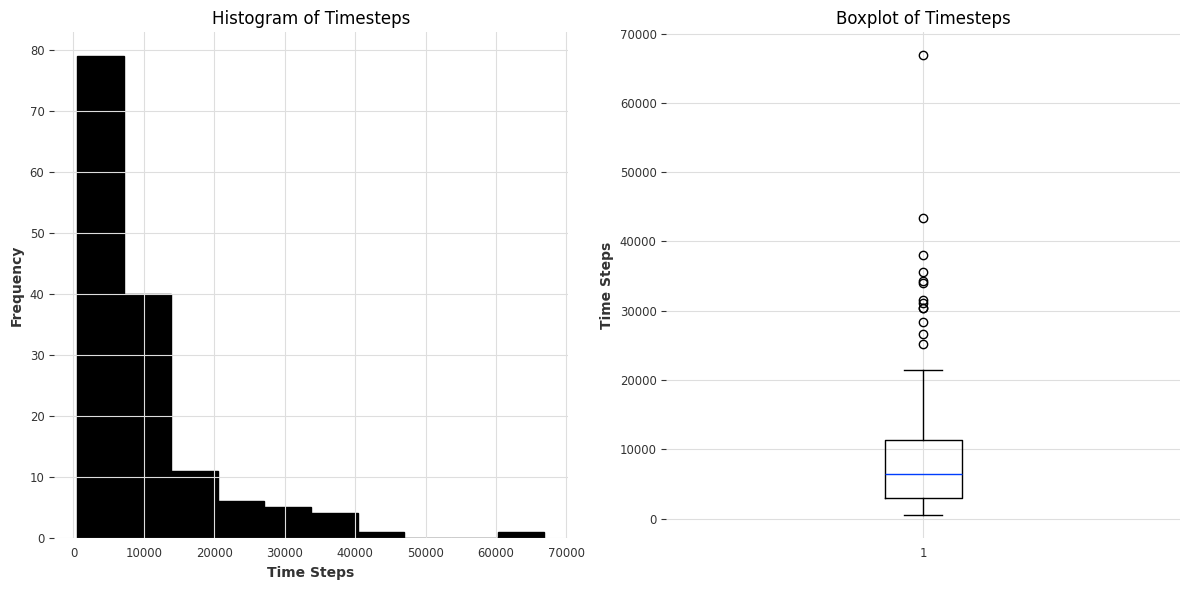

In [36]:
id_data = pd.DataFrame([(ts.static_covariates['ID'][0],ts.n_timesteps) for ts in ts_g],
                       columns=['ID','n_timesteps'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
axes[0].hist(id_data['n_timesteps'], edgecolor='black')
axes[0].set_title('Histogram of Timesteps')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(id_data['n_timesteps'])
axes[1].set_title('Boxplot of Timesteps')
axes[1].set_ylabel('Time Steps')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
id_data.describe()

,ID,n_timesteps
count,147.000000,147.000000
mean,74.000000,9595.578231
std,42.579338,9814.460770
min,1.000000,576.000000
25%,37.500000,2976.500000
50%,74.000000,6459.000000
75%,110.500000,11304.500000
max,147.000000,66857.000000


In [38]:
# missing values
series_num = 60
ts_g[series_num].gaps()['gap_size'].sum()/ts_g[series_num].n_timesteps

0.01718597177588375

Notes about the ID:
We have 147 IDs that on average have about 9000 observations. I'm curious if heart rate trends up over time. Maybe the longer someone is at the hospital, the more likely they are to experience an adverse event

When we get to multi-variate analysis, I'll be looking for how much variation in heart rate within each series and how much variation there is between series

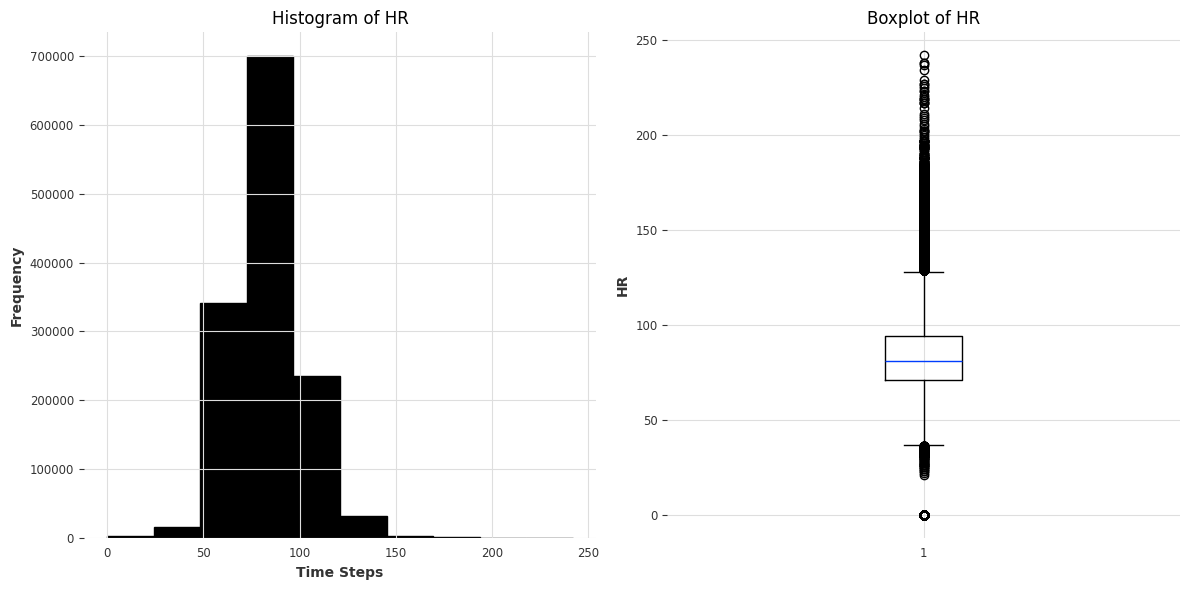

In [39]:
hr_data = pd.concat([ts['SIGNAL_VALUE_HR'].pd_dataframe() for ts in ts_g])

hr_data.describe()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Histogram
axes[0].hist(hr_data['SIGNAL_VALUE_HR'], edgecolor='black')
axes[0].set_title('Histogram of HR')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# # Boxplot
axes[1].boxplot(hr_data.loc[~hr_data['SIGNAL_VALUE_HR'].isna()]['SIGNAL_VALUE_HR'])
axes[1].set_title('Boxplot of HR')
axes[1].set_ylabel('HR')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
hr_data.describe()

component,SIGNAL_VALUE_HR
count,1.329900e+06
mean,8.310964e+01
std,1.778697e+01
min,0.000000e+00
25%,7.100000e+01
50%,8.100000e+01
75%,9.400000e+01
max,2.420000e+02


#### SPO2

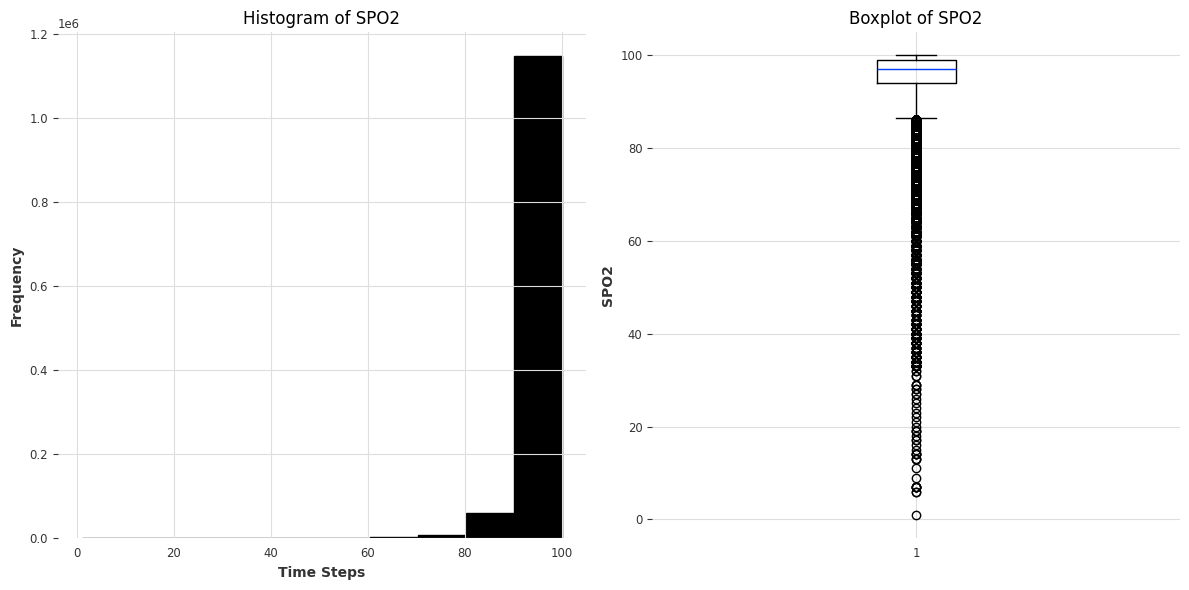

In [41]:
hr_data = pd.concat([ts['SIGNAL_VALUE_SPO2'].pd_dataframe() for ts in ts_g])

hr_data.describe()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Histogram
axes[0].hist(hr_data['SIGNAL_VALUE_SPO2'], edgecolor='black')
axes[0].set_title('Histogram of SPO2')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# # Boxplot
axes[1].boxplot(hr_data.loc[~hr_data['SIGNAL_VALUE_SPO2'].isna()]['SIGNAL_VALUE_SPO2'])
axes[1].set_title('Boxplot of SPO2')
axes[1].set_ylabel('SPO2')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Multivariate Analysis

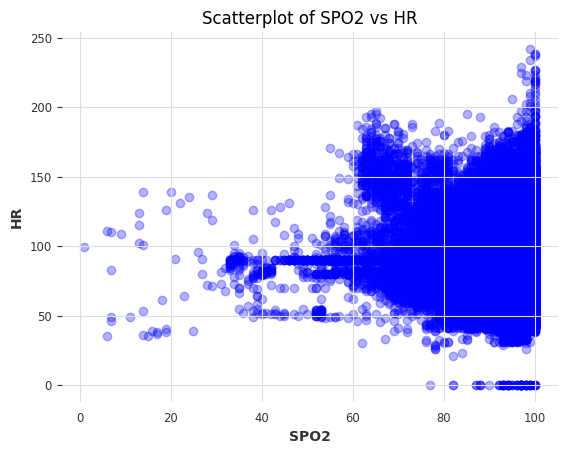

In [42]:
# correlation between HR and SP02
# correlation between lag HR and lag SPO2 - hypothesis: drop in SPO2 correlates with change in HR
df_filled_agg.head()

plt.scatter(df_filled_agg['SIGNAL_VALUE_SPO2'], 
            df_filled_agg['SIGNAL_VALUE_HR'],
            color = 'blue',
            alpha=0.3)

# Add labels and title
plt.xlabel('SPO2')
plt.ylabel('HR')
plt.title('Scatterplot of SPO2 vs HR')

# Show the plot
plt.show()

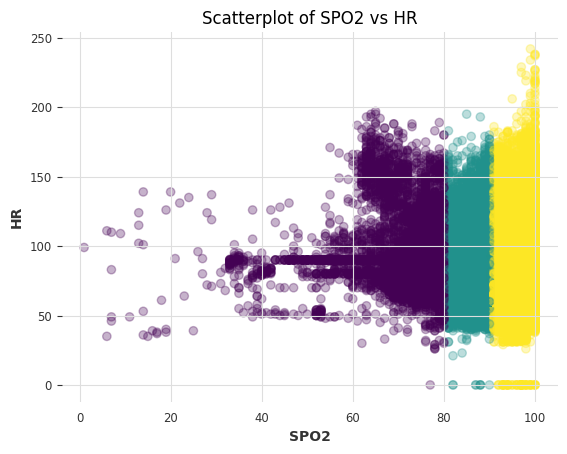

In [43]:
# add bins to SPO2
bins = [0, 80, 90, 1000]
labels = [1,2,3]
df_filled_agg['SPO2_binned'] = pd.cut(df_filled_agg['SIGNAL_VALUE_SPO2'], bins=bins, labels=labels)
df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_SPO2'] == 80].head()


plt.scatter(df_filled_agg['SIGNAL_VALUE_SPO2'], 
            df_filled_agg['SIGNAL_VALUE_HR'],
            c = df_filled_agg['SPO2_binned'],
            alpha=0.3)

# Add labels and title
plt.xlabel('SPO2')
plt.ylabel('HR')
plt.title('Scatterplot of SPO2 vs HR')

# Show the plot
plt.show()

No clear relationship, but variance is not constant

#### Stationarity

In [44]:
from darts.utils.statistics import stationarity_test_adf
from darts.dataprocessing.transformers import MissingValuesFiller

def cw_stationarity_tester(ts: TimeSeries) -> bool:
    """Fill """
    transformer = MissingValuesFiller()
    ts_tf = transformer.transform(ts) 
    # check: if statistic is below p-value, cannot reject null -> non-stationary
    test_res = stationarity_test_adf(ts_tf,
                                     maxlag=None,
                                     regression='c',
                                     autolag='AIC')
    
    if test_res[0] < test_res[4]['5%']:
        return True # stationary
    else:
        return False # non stationary
test_res = cw_stationarity_tester(ts_g[7]['SIGNAL_VALUE_HR'])
sum([cw_stationarity_tester(ts['SIGNAL_VALUE_HR']) for ts in ts_g])

116

Most of our series are stationary

#### Variance by hour of stay

## Data Preprocessing Pipeline

### Feature Engineering

#### Date/Time Related Features
Because we're given time since start in seconds, we don't have date or time related features. However, given that heart rates may fluctuate during sleep, maybe we should explore 24 cycles

#### Lags
Using darts, we will handle lags using an argument. What number of lags should we include?

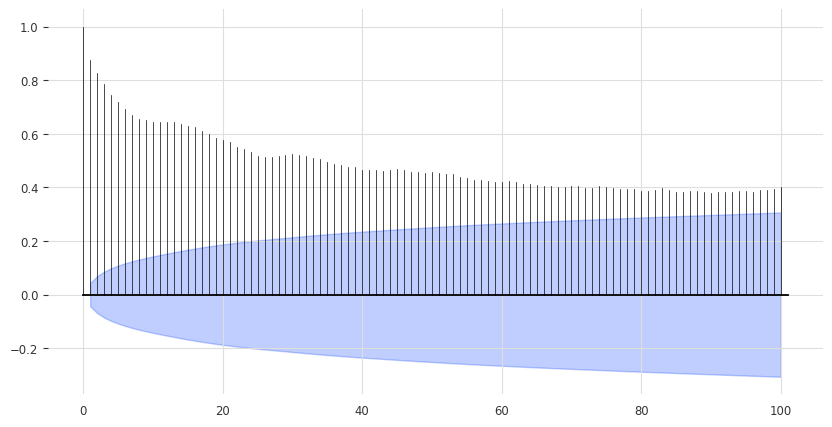

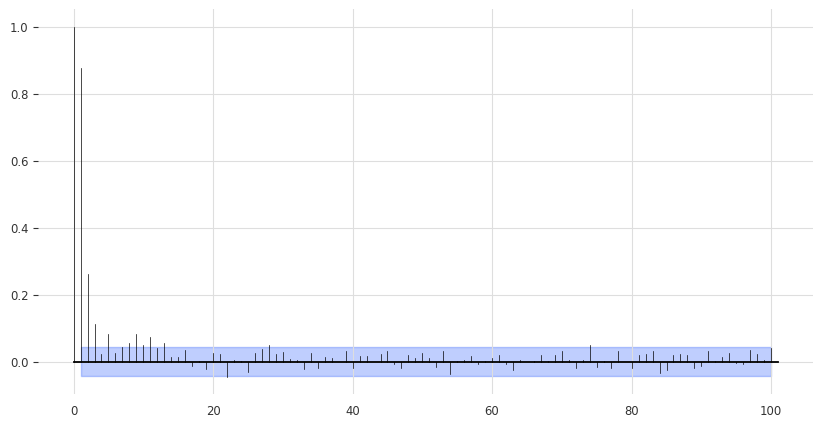

In [45]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf
# ts_g[0]['SIGNAL_VALUE_HR'].plot()
plot_acf(ts_g[2].head(2050)['SIGNAL_VALUE_HR'],max_lag=100)
plot_pacf(ts_g[2].head(2050)['SIGNAL_VALUE_HR'],max_lag=100)
# plot_pacf(ts_g[2].head(200)['SIGNAL_VALUE_HR'],m=10,max_lag=25)

#### Domain Specific Features

- From wikipedia: SPO2 is typically between 96-100. Below 90 is considered low and below 80 is considered dangerous
- Difference in expanding median and rolling average

In [46]:

bins = [0, 80, 90, 1000]
labels = [1,2,3]
df_filled_agg['SPO2_binned'] = pd.cut(df_filled_agg['SIGNAL_VALUE_SPO2'], bins=bins, labels=labels)
df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_SPO2'] == 80].head()

,ID,n_time_steps,TIME_SINCE_START_IN_SECONDS,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2,time_diff,time_step,SPO2_binned
4179,1,4179,125366.0,118.0,80.0,30.0,1.0,1
10598,3,0,30.0,85.0,80.0,0.0,0.0,1
20091,5,5588,167619.0,128.0,80.0,30.0,1.0,1
22585,5,8082,242413.0,99.0,80.0,30.0,1.0,1
23553,5,9050,271446.0,105.0,80.0,30.0,1.0,1


#### Rolling Window Features

In [47]:
from darts.dataprocessing.transformers import WindowTransformer
from darts.dataprocessing.pipeline import Pipeline

mv_transformer = MissingValuesFiller()

w_transformer = WindowTransformer(transforms=[{"function":"mean",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":20},
                                             {"function":"std",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "treat_na":"dropna",
                                             "window":20}],
                                             keep_non_transformed=True
                                             )



# next steps: figure out testing strategy, finish feature engineering, test model end to end!, FFT for cyclical components (EDA)

component,rolling_mean_20_SIGNAL_VALUE_HR,rolling_mean_20_SIGNAL_VALUE_SPO2,rolling_std_20_SIGNAL_VALUE_HR,rolling_std_20_SIGNAL_VALUE_SPO2,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2
n_time_steps,,,,,,
0,112.000000,98.000000,0.000000,0.707107,112.0,98.0
1,112.000000,98.500000,0.000000,0.707107,112.0,99.0
2,112.333333,98.333333,0.577350,0.577350,113.0,98.0
3,112.000000,98.500000,0.816497,0.577350,111.0,99.0
4,112.000000,98.400000,0.707107,0.547723,112.0,98.0
...,...,...,...,...,...,...
5342,52.150000,99.875000,2.960708,0.319333,55.0,100.0
5343,52.300000,99.675000,3.079645,0.921598,56.0,96.0
5344,52.900000,99.475000,3.712000,1.229837,62.0,96.0


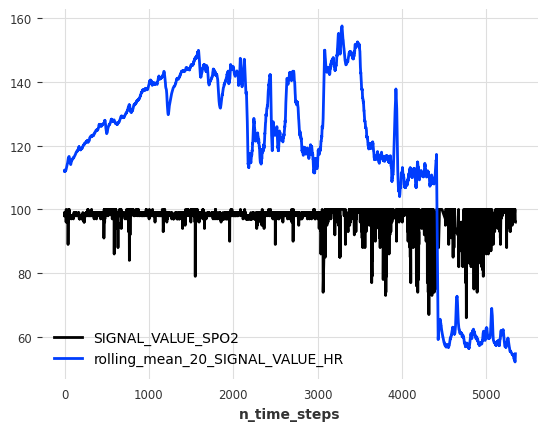

In [48]:
# pipeline
pipeline = Pipeline([mv_transformer, w_transformer,mv_transformer])
ts_tf = pipeline.fit_transform(ts_g)
# tf_test['SIGNAL_VALUE_HR'].plot()
ts_tf[0]['SIGNAL_VALUE_SPO2'].plot()
ts_tf[0]['rolling_mean_20_SIGNAL_VALUE_HR'].plot()
ts_tf[0].pd_dataframe()

In [49]:
df_filled_agg.head()

,ID,n_time_steps,TIME_SINCE_START_IN_SECONDS,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2,time_diff,time_step,SPO2_binned
0,1,0,30.0,112.0,98.0,0.0,0.0,3
1,1,1,60.0,112.0,99.0,30.0,1.0,3
2,1,2,90.0,113.0,98.0,30.0,1.0,3
3,1,3,120.0,111.0,99.0,30.0,1.0,3
4,1,4,150.0,112.0,98.0,30.0,1.0,3


## Model Development

### Baseline Model

#### Local Model

<Axes: xlabel='n_time_steps'>

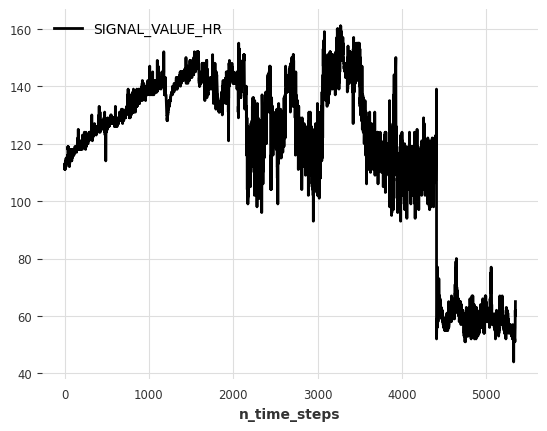

In [50]:
ts = ts_tf[0]
ts['SIGNAL_VALUE_HR'].plot()

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from darts.models import LinearRegressionModel

# extract covariate series
ts_cov = ts[["SIGNAL_VALUE_SPO2","rolling_std_20_SIGNAL_VALUE_SPO2"]]
ts_cov = ts[["rolling_std_20_SIGNAL_VALUE_SPO2"]]

# ts_SPO2_std = ts["rolling_std_20_SIGNAL_VALUE_SPO2"]


# extract target series
ts_HR = ts["SIGNAL_VALUE_HR"]

# create train and validation splits
validation_cutoff = 3000
ts_HR_train, ts_HR_val = ts_HR.split_after(validation_cutoff)

# ts_HR.plot()
# plt.show()

# ts_SPO2.plot()
# plt.show()

/workspaces/ts-dl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# from darts.dataprocessing.transformers import MissingValuesFiller

# transformer = MissingValuesFiller()
# ts_HR_train_tf = transformer.transform(ts_HR_train)

# ts_SPO2_tf = transformer.transform(ts_SPO2)
# ts_SPO2_tf.plot()

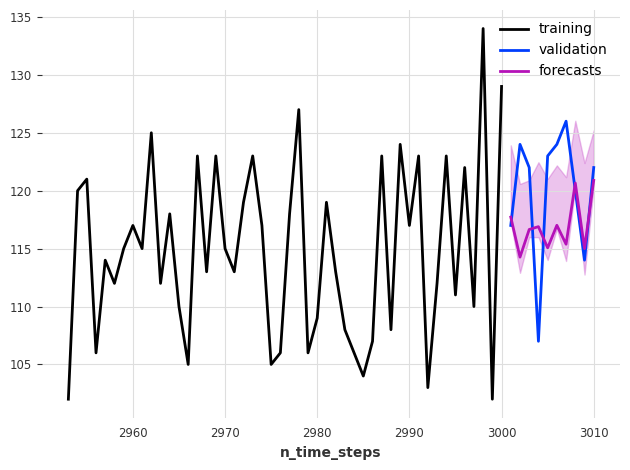

In [53]:
model = LinearRegressionModel(lags=20, 
                              output_chunk_length=10, 
                              lags_past_covariates=10,
                              multi_models=False,
                              likelihood='quantile', 
                              quantiles=[.2,.5,.8])
model.fit(ts_HR_train, past_covariates=ts_cov)
# pred = model.predict(10)

# ts_HR_train_tf[-48:].plot(label="training")
# ts_HR_val[:10].plot(label="validation")
# pred.plot(label="forecast")


pred_samples = model.predict(n=10, num_samples=200)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

# for val, comp in zip(pred_params.values()[0], pred_params.components):
#     print(f"{comp} : {round(val, 3)}")

ts_HR_train[-48:].plot(label="training")
ts_HR_val[:10].plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()

# set up backtest methodology to do historical forecasts: https://unit8co.github.io/darts/quickstart/00-quickstart.html#Backtesting:-simulate-historical-forecasting

##### Local Evaluation

In [54]:
hfc_params = {
    "series": ts_HR,
    "start": validation_cutoff,  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 10,
    "num_samples": 200,
    "overlap_end":True,
    "verbose": False,
}

<Axes: xlabel='n_time_steps'>

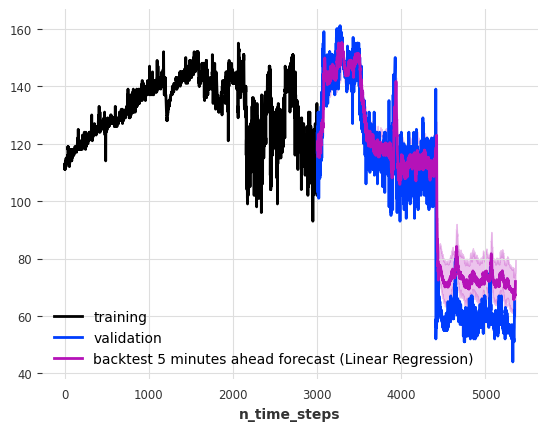

In [55]:
historical_fcast_lin_reg = model.historical_forecasts(
    last_points_only=True,
    past_covariates = ts_cov,
    retrain = False,
      **hfc_params
)

ts_HR_train.plot(label="training")
ts_HR_val.plot(label="validation")
historical_fcast_lin_reg.plot(label="backtest 5 minutes ahead forecast (Linear Regression)")

In [56]:
from darts.metrics.metrics import mql, qr

print(mql(ts_HR_val,historical_fcast_lin_reg))
print(qr(ts_HR_val,historical_fcast_lin_reg))

8.702177697929237
0.06705838114645697


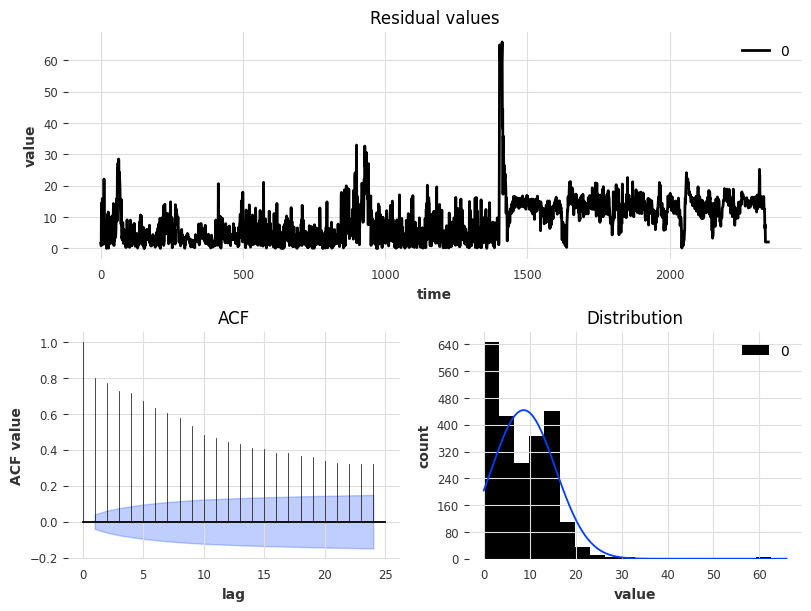

In [57]:
from darts.utils.statistics import plot_residuals_analysis
from darts.metrics.metrics import ae

residuals = model.residuals(
    historical_forecasts=historical_fcast_lin_reg,
    metric=ae,  # the absolute error per time step
    last_points_only=True,
    values_only=True,  # return a list of numpy arrays
    **hfc_params,
)
# residuals
plot_residuals_analysis(TimeSeries.from_values(residuals.squeeze()))



#### Global Model

<Axes: xlabel='n_time_steps'>

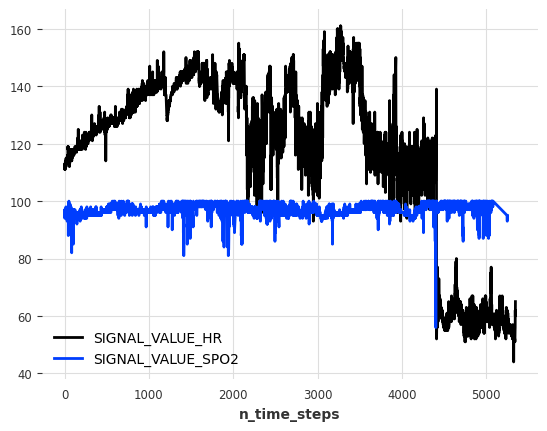

In [58]:

ts_g_sample = ts_tf[:5]

ts_g_sample[0]['SIGNAL_VALUE_HR'].plot()
ts_g_sample[1]['SIGNAL_VALUE_SPO2'].plot()

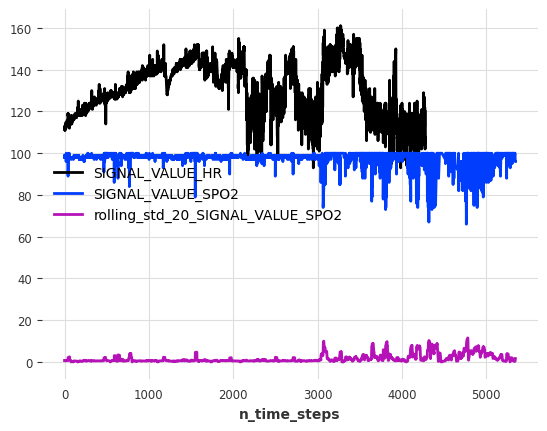

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from darts.models import LinearRegressionModel

# extract covariate series
ts_g_cov = [ts[["SIGNAL_VALUE_SPO2","rolling_std_20_SIGNAL_VALUE_SPO2"]] for ts in ts_g_sample]

# extract target series
ts_g_HR = [ts["SIGNAL_VALUE_HR"] for ts in ts_g_sample]

# create train and validation splits
validation_cutoff = 0.8
ts_splits = [ts.split_after(validation_cutoff) for ts in ts_g_HR]
ts_g_HR_train = [ts[0] for ts in ts_splits]
ts_g_HR_val = [ts[1] for ts in ts_splits]
# ts_HR_train, ts_HR_val = [ts_HR.split_after(validation_cutoff)]

ts_g_HR_train[0].plot()
ts_g_cov[0].plot()
plt.show()


In [60]:
model = LinearRegressionModel(lags=20, 
                              output_chunk_length=10, 
                              lags_past_covariates=10,
                              multi_models=False,
                              likelihood='quantile', 
                              quantiles=[.2,.5,.8])
model.fit(ts_g_HR_train, past_covariates=ts_g_cov)

LinearRegressionModel(lags=20, lags_past_covariates=10, lags_future_covariates=None, output_chunk_length=10, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.2, 0.5, 0.8], random_state=None, multi_models=False, use_static_covariates=True)

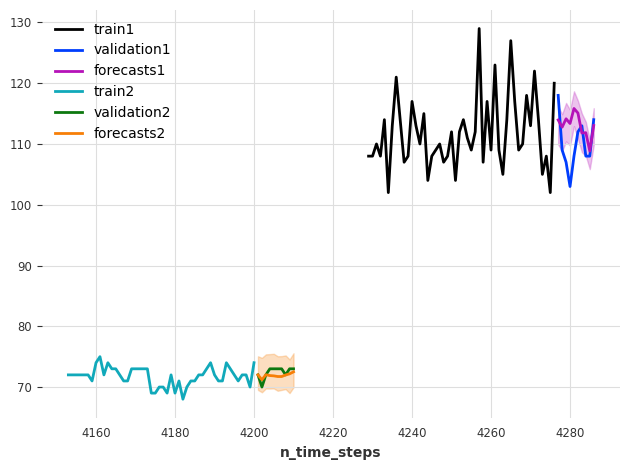

In [61]:
pred_samples = model.predict(series=ts_g_HR_train,
                             past_covariates=ts_g_cov,
                             n=10, 
                             num_samples=200)
# pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

ts_g_HR_train[0][-48:].plot(label="train1")
ts_g_HR_val[0][:10].plot(label="validation1")
pred_samples[0].plot(label="forecasts1")


ts_g_HR_train[1][-48:].plot(label="train2")
ts_g_HR_val[1][:10].plot(label="validation2")
pred_samples[1].plot(label="forecasts2")
plt.tight_layout()

Baseline models show that predictions not well calibrated, validation is too often outside 80% CI

##### Global Evaluation

In [62]:
hfc_params = {
    "series": ts_g_HR,
    "start": validation_cutoff,  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 10,
    "num_samples": 200,
    "overlap_end":True,
    "verbose": False,
}

<Axes: xlabel='n_time_steps'>

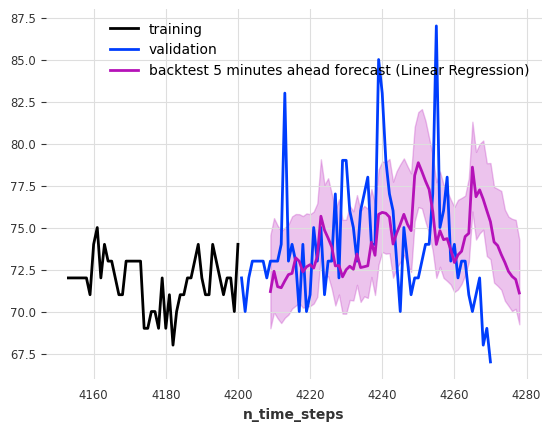

In [63]:
historical_fcast_lin_reg = model.historical_forecasts(
    last_points_only=True,
    past_covariates = ts_g_cov,
    retrain = False,
      **hfc_params
)

ts_g_HR_train[1].tail(48).plot(label="training")
ts_g_HR_val[1][:70].plot(label="validation")
historical_fcast_lin_reg[1][:70].plot(label="backtest 5 minutes ahead forecast (Linear Regression)")

###### Note
Example of a forecast miss? slow to react to dropping heart rate?

In [64]:
print(mql(ts_g_HR_val,historical_fcast_lin_reg))
print(qr(ts_g_HR_val,historical_fcast_lin_reg))

[3.6580534320347025, 3.2350631253179247, 1.0167581643137138, 0.6536812012192698, 4.361467170453462]
[0.019323243902225735, 0.001980585530701813, 0.005143193937178624, inf, 0.0012176055487513578]


/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/metrics/metrics.py:3116: RuntimeWarning: divide by zero encountered in divide
  return losses / z_true


### Deep Learning Models

In [65]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import concatenate
from darts.dataprocessing.transformers.scaler import Scaler
from darts.metrics import mql
from darts.models import TFTModel, TSMixerModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression

#### Darts Implementation

In [159]:
ts_dl_sample = [ts[["SIGNAL_VALUE_HR","SIGNAL_VALUE_SPO2",
                    "rolling_std_20_SIGNAL_VALUE_SPO2",
                    "rolling_std_20_SIGNAL_VALUE_HR"]] for ts in ts_tf[:5]]

train, val, test = [], [], []
for ts in ts_dl_sample:
    train_, temp = ts.split_after(0.6)
    val_, test_ = temp.split_after(0.5)
    train.append(train_)
    val.append(val_)
    test.append(test_)

In [160]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [161]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    full_training=True,
):
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256
    else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 40
        batch_size = 64

    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False
    )
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],
    }

    # optimizer setup, uses Adam by default
    # optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = QuantileRegression()
    loss_fn = None

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        # "add_encoders": {
        #     "cyclic": {
        #         "future": ["hour", "dayofweek", "month"]
        #     }  # add cyclic time axis encodings as future covariates
        # },
    }

In [162]:
input_chunk_length = 5 * 10 # use 1 hr to predict 5 minutes
output_chunk_length = 10
use_static_covariates = True
full_training = False

In [163]:
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm",
)

model_tfm = TFTModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training
    ),
    use_static_covariates=use_static_covariates,
    add_relative_index=True,
    model_name="tfm",
)

In [164]:
models = {
    "TSM": model_tsm,
    "TFM": model_tfm
}

In [165]:
for model_name, model in models.items():
    model.fit(
        series=train,
        val_series=val,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[model_name] = model.load_from_checkpoint(
        model_name=model.model_name, best=True
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | train_metrics       | MetricCollection | 0      | train
1 | val_metrics         | MetricCollection | 0      | train
2 | rin                 | RINorm           | 8      | train
3 | fc_hist             | Linear           | 510    | train
4 | feature_mixing_hist | _FeatureMixing   | 6.1 K  | train
5 | conditional_mixer   | ModuleList       | 60.6 K | train
6 | fc_out              | Linear           | 4.4 K  | train
-----------------------------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 20/20 [00:00<00:00, 37.12it/s, train_loss=0.299, val_loss=0.512]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 20/20 [00:00<00:00, 35.14it/s, train_loss=0.299, val_loss=0.512]


/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchFore

Epoch 39: 100%|██████████| 20/20 [00:01<00:00, 14.43it/s, train_loss=0.425, val_loss=0.672]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 20/20 [00:01<00:00, 13.85it/s, train_loss=0.425, val_loss=0.672]


/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchFore

In [166]:
# concatenate val and test for backtesting
val_test = [ts[0].concatenate(ts[1]) for ts in zip(val,test)]

In [167]:
zip(val,test)

In [168]:
# configure the probabilistic prediction
num_samples = 200
forecast_horizon = output_chunk_length

# compute the Mean Quantile Loss over these quantiles
evaluate_quantiles = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]


def historical_forecasts(model):
    """Generates probabilistic historical forecasts for each transformer
    and returns the inverse transformed results.

    Each forecast covers 24h (forecast_horizon). The time between two forecasts
    (stride) is also 24 hours.
    """
    hfc = model.historical_forecasts(
        series=val_test,
        forecast_horizon=forecast_horizon,
        stride=1,
        last_points_only=True,
        retrain=False,
        num_samples=num_samples,
        verbose=True,
    )
    return scaler.inverse_transform(hfc)


def backtest(model, hfc, name):
    """Evaluates probabilistic historical forecasts using the Mean Quantile
    Loss (MQL) over a set of quantiles."""
    # add metric specific kwargs
    metric_kwargs = [{"q": q} for q in evaluate_quantiles]
    metrics = [mql for _ in range(len(evaluate_quantiles))]
    bt = model.backtest(
        series=ts_dl_sample,
        historical_forecasts=hfc,
        last_points_only=True,
        metric=metrics,
        metric_kwargs=metric_kwargs,
        verbose=True,
    )
    # bt = pd.DataFrame(
    #     bt,
    #     columns=[f"q_{q}" for q in evaluate_quantiles],
    #     index=[f"{trafo}_{name}" for trafo in ["SIGNAL_VALUE_HR"]],
    # )
    return bt


def generate_plots(n_days, hfcs):
    """Plot the probabilistic forecasts for each model, transformer and transformer
    feature against the ground truth."""
    # concatenate historical forecasts into contiguous time series
    # (works because forecast_horizon=stride)
    hfcs_plot = {}
    for model_name, hfc_model in hfcs.items():
        hfcs_plot[model_name] = [
            concatenate(hfc_series[-n_days:], axis=0) for hfc_series in hfc_model
        ]

    # remember start and end points for plotting the target series
    hfc_ = hfcs_plot[model_name][0]
    start, end = hfc_.start_time(), hfc_.end_time()

    # for each target column...
    for col in ts_g_sample[0].columns:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
        # ... and for each transformer...
        for trafo_idx, trafo in enumerate(ts_g_sample):
            trafo[col][start:end].plot(label="ground truth", ax=axes[trafo_idx])
            # ... plot the historical forecasts for each model
            for model_name, hfc in hfcs_plot.items():
                hfc[trafo_idx][col].plot(
                    label=model_name + "_q0.05-q0.95", ax=axes[trafo_idx]
                )
            axes[trafo_idx].set_title(f"ETTh{trafo_idx + 1}: {col}")
        plt.show()

In [169]:
bts = {}
hfcs = {}
for model_name, model in models.items():
    print(f"Model: {model_name}")
    print("Generating historical forecasts..")
    hfcs[model_name] = historical_forecasts(models[model_name])

    print("Evaluating historical forecasts..")
    bts[model_name] = backtest(models[model_name], hfcs[model_name], model_name)

Model: TSM

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Generating historical forecasts..
Predicting DataLoader 0: 100%|██████████| 151/151 [01:58<00:00,  1.27it/s]
Evaluating historical forecasts..


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model: TFM
Generating historical forecasts..
Predicting DataLoader 0: 100%|██████████| 151/151 [07:01<00:00,  2.79s/it]
Evaluating historical forecasts..


<Axes: xlabel='time'>

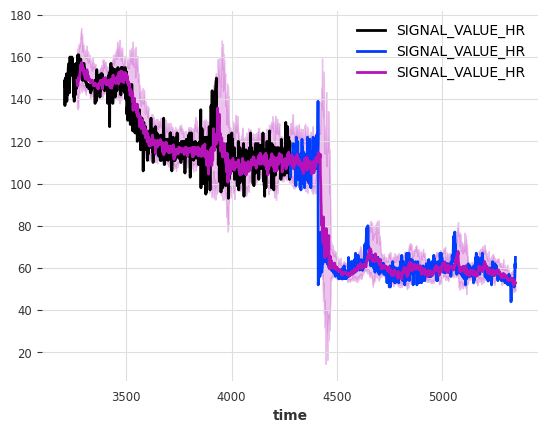

In [170]:
# scaler.inverse_transform(train)[0].plot()
scaler.inverse_transform(val)[0]['SIGNAL_VALUE_HR'].plot()
scaler.inverse_transform(test)[0]['SIGNAL_VALUE_HR'].plot()
hfcs['TSM'][0]['SIGNAL_VALUE_HR'].plot()

<Axes: xlabel='time'>

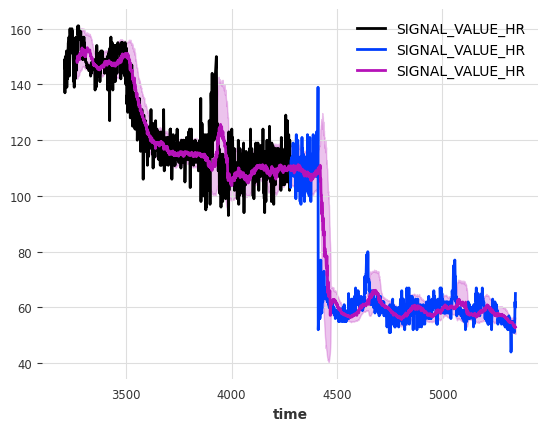

In [171]:
# scaler.inverse_transform(train)[0].plot()
scaler.inverse_transform(val)[0]['SIGNAL_VALUE_HR'].plot()
scaler.inverse_transform(test)[0]['SIGNAL_VALUE_HR'].plot()
hfcs['TFM'][0]['SIGNAL_VALUE_HR'].plot()

###### Note
^ Interesting that CI is large, that itself can be part of prediction envelope

In [223]:
# split hfcs into val and test
from scipy.stats import percentileofscore
hfcs['TFM'][0].quantiles_df(quantiles=[.2,.8])[['SIGNAL_VALUE_HR_0.2','SIGNAL_VALUE_HR_0.8']]
hfcs['TFM'][0].slice_intersect(val[0]).quantiles_df([.2,.8])[['SIGNAL_VALUE_HR_0.2','SIGNAL_VALUE_HR_0.8']]

hfcs_tfm_val = [ts[0].slice_intersect(ts[1]) for ts in zip(hfcs['TFM'],val)]
hfcs_tfm_test = [ts[0].slice_intersect(ts[1]) for ts in zip(hfcs['TFM'],test)]

hfcs_tfm_spreads = [ts.quantiles_df([.2,.8])[['SIGNAL_VALUE_HR_0.2','SIGNAL_VALUE_HR_0.8']] for ts in hfcs_tfm_val]
hfcs_tfm_spread = pd.concat(hfcs_tfm_spreads)
hfcs_tfm_spread['HR_SPREAD'] = hfcs_tfm_spread['SIGNAL_VALUE_HR_0.8'] -  hfcs_tfm_spread['SIGNAL_VALUE_HR_0.2']
hfcs_tfm_spread['HR_SPREAD']

hfcs_tfm_preds = [ts.quantiles_df([.2,.8])[['SIGNAL_VALUE_HR_0.2','SIGNAL_VALUE_HR_0.8']] for ts in hfcs_tfm_test]
hfcs_tfm_pred = pd.concat(hfcs_tfm_preds)
hfcs_tfm_pred['HR_SPREAD'] = hfcs_tfm_pred['SIGNAL_VALUE_HR_0.8'] -  hfcs_tfm_pred['SIGNAL_VALUE_HR_0.2']
hfcs_tfm_pred['HR_SPREAD_PERCENTILE'] = percentileofscore(hfcs_tfm_spread['HR_SPREAD'],hfcs_tfm_pred['HR_SPREAD'])
hfcs_tfm_pred
# # calculate distribution of spread
# percentileofscore(hfcs_tfm_spread['HR_SPREAD'],50)
# apply to spread of predictions in test set

# test set 

component,SIGNAL_VALUE_HR_0.2,SIGNAL_VALUE_HR_0.8,HR_SPREAD,HR_SPREAD_PERCENTILE
time,,,,
4278,105.923715,114.299520,8.375805,66.952422
4279,106.545703,115.511509,8.965806,71.645949
4280,106.011558,115.863662,9.852105,77.903986
4281,105.898721,115.784378,9.885657,78.118303
4282,106.027865,113.723180,7.695315,60.180026
...,...,...,...,...
10296,80.472302,96.022852,15.550550,94.599228
10297,80.447791,97.383453,16.935662,95.777968
10298,81.249320,97.235617,15.986296,94.899271


In [173]:
print(pd.DataFrame(bts['TSM']).mean().mean())

print(pd.DataFrame(bts['TFM']).mean().mean())

1.6901471228348832
1.9358553558198863


#### Deep Learning Explainability

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.76it/s]


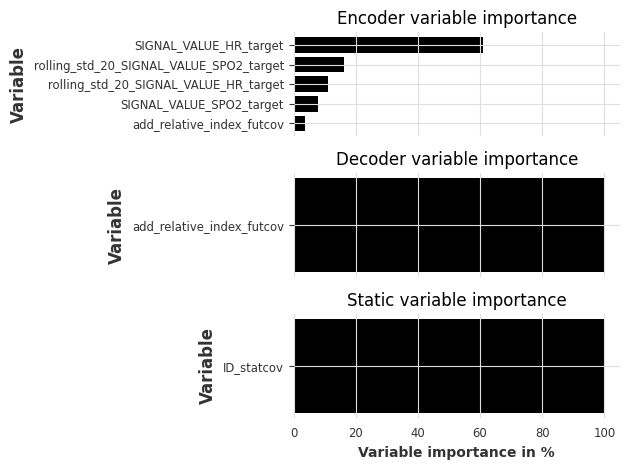

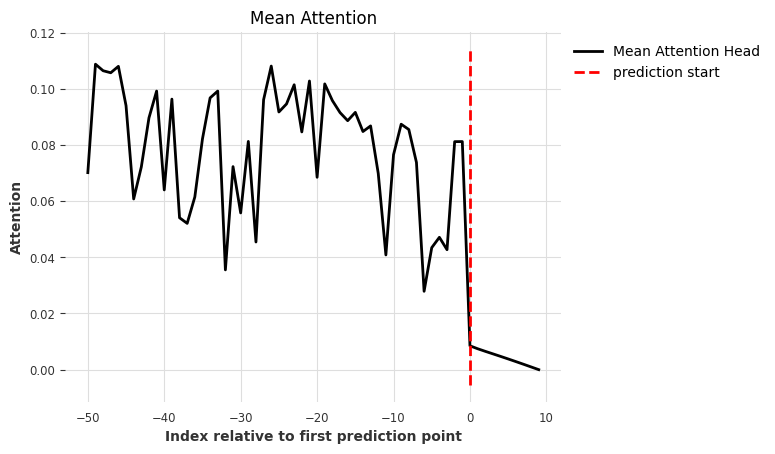

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [174]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(model_tfm,
                         background_series=ts_dl_sample[2])
explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result)
explainer.plot_attention(explainability_result, plot_type="time")

In [175]:
model_tfm.predict(series=train[0],n=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.12it/s] 


<TimeSeries (DataArray) (n_time_steps: 1, component: 4, sample: 1)> Size: 32B
array([[[0.83310819],
        [0.91466579],
        [0.14238284],
        [0.19875381]]])
Coordinates:
  * n_time_steps  (n_time_steps) int64 8B 3208
  * component     (component) object 32B 'SIGNAL_VALUE_HR' ... 'rolling_std_2...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   ID\nglobal_components  1.0
    hierarchy:          None

###### More explainability: Captum

# Notes

- https://unit8co.github.io/darts/userguide/forecasting_overview.html#handling-multiple-series see probabilistic NN section